# Dengue Fever Spread Predicting Based on Ensemble Learning and MCMC Method

# Data Collection and Preliminary Understanding

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import periodogram

from IPython.display import Image 

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from tpot import TPOTRegressor

In [4]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

In [5]:
import pymc3 as pm
import theano.tensor as tt

In [6]:
from scipy.optimize import minimize

In [7]:
df_f = pd.read_csv("DengAI_Predicting_Disease_Spread_-_Training_Data_Features.csv")
df_l = pd.read_csv("DengAI_Predicting_Disease_Spread_-_Training_Data_Labels.csv")

In [8]:
df_f

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


In [9]:
df_l

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
...,...,...,...,...
1451,iq,2010,21,5
1452,iq,2010,22,8
1453,iq,2010,23,1
1454,iq,2010,24,1


In [10]:
df = pd.concat([df_f,df_l['total_cases']],axis = 1)

In [11]:
df

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


In [12]:
df.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

In [13]:
df['week_start_date'] = pd.to_datetime(df['week_start_date'])

In [14]:
sj = df[df['city']=='sj']

In [15]:
sj.dtypes

city                                             object
year                                              int64
weekofyear                                        int64
week_start_date                          datetime64[ns]
ndvi_ne                                         float64
ndvi_nw                                         float64
ndvi_se                                         float64
ndvi_sw                                         float64
precipitation_amt_mm                            float64
reanalysis_air_temp_k                           float64
reanalysis_avg_temp_k                           float64
reanalysis_dew_point_temp_k                     float64
reanalysis_max_air_temp_k                       float64
reanalysis_min_air_temp_k                       float64
reanalysis_precip_amt_kg_per_m2                 float64
reanalysis_relative_humidity_percent            float64
reanalysis_sat_precip_amt_mm                    float64
reanalysis_specific_humidity_g_per_kg           

In [16]:
sj.shape

(936, 25)

In [17]:
sj = sj.drop(['city','year'],axis=1)

In [18]:
sj[sj['precipitation_amt_mm']!=sj['reanalysis_sat_precip_amt_mm']]

,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
87,1,1992-01-01,0.12510,0.157867,0.185283,0.181367,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81
93,7,1992-02-12,NaN,0.130500,0.195743,0.178857,NaN,297.798571,298.057143,294.650000,...,82.875714,NaN,16.060000,2.200000,26.028571,6.571429,32.2,20.0,1.3,65
94,8,1992-02-19,NaN,0.184467,0.194614,0.203057,NaN,297.898571,298.107143,293.628571,...,77.295714,NaN,15.012857,2.585714,25.757143,7.385714,33.9,21.7,8.9,33
95,9,1992-02-26,0.10705,0.081500,0.165243,0.163057,NaN,297.472857,297.678571,292.967143,...,76.037143,NaN,14.381429,2.414286,25.285714,6.171429,29.4,21.7,16.0,38
139,53,1993-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30
399,1,1998-01-01,0.04550,0.047800,0.123986,0.083443,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64
451,53,1999-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59
711,1,2004-01-01,-0.26830,-0.123700,0.223757,0.176543,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
763,53,2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


In [19]:
sj = sj.drop(['reanalysis_sat_precip_amt_mm'],axis=1)

In [20]:
def convert_to_celsius(df,k):
    for i in k:
        df[i[:-1]+'c'] = df[i] - 273.15
    return df

In [21]:
k_t_list = ['reanalysis_air_temp_k','reanalysis_avg_temp_k','reanalysis_dew_point_temp_k',
            'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k']
convert_to_celsius(sj,k_t_list)

,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,reanalysis_air_temp_c,reanalysis_avg_temp_c,reanalysis_dew_point_temp_c,reanalysis_max_air_temp_c,reanalysis_min_air_temp_c
0,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,6.900000,29.4,20.0,16.0,4,24.422857,24.592857,19.264286,26.65,22.75
1,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,6.371429,31.7,22.2,8.6,5,25.061429,25.292857,20.801429,27.75,23.25
2,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,6.485714,32.2,22.8,41.4,4,25.631429,25.728571,22.284286,27.35,24.15
3,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,6.771429,33.3,23.3,4.0,3,25.837143,26.078571,22.160000,28.25,23.85
4,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,9.371429,35.0,23.9,5.8,6,26.368571,26.514286,22.671429,28.75,24.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,13,2008-03-25,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,...,5.785714,30.0,21.1,1.8,4,23.808571,23.807143,18.945714,26.55,21.25
932,14,2008-04-01,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,...,6.814286,30.6,22.2,0.5,3,24.931429,25.078571,20.085714,26.65,23.35
933,15,2008-04-08,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,...,5.714286,29.4,21.7,30.7,1,24.310000,24.414286,19.582857,26.25,22.65
934,16,2008-04-15,0.001800,NaN,0.203900,0.209843,0.00,297.630000,297.778571,292.274286,...,6.242857,29.4,21.7,11.2,3,24.480000,24.628571,19.124286,26.55,22.75


In [22]:
sj = sj.drop(k_t_list,axis=1)

In [23]:
sj

,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,...,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,reanalysis_air_temp_c,reanalysis_avg_temp_c,reanalysis_dew_point_temp_c,reanalysis_max_air_temp_c,reanalysis_min_air_temp_c
0,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,32.00,73.365714,14.012857,...,6.900000,29.4,20.0,16.0,4,24.422857,24.592857,19.264286,26.65,22.75
1,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,17.94,77.368571,15.372857,...,6.371429,31.7,22.2,8.6,5,25.061429,25.292857,20.801429,27.75,23.25
2,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,26.10,82.052857,16.848571,...,6.485714,32.2,22.8,41.4,4,25.631429,25.728571,22.284286,27.35,24.15
3,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,13.90,80.337143,16.672857,...,6.771429,33.3,23.3,4.0,3,25.837143,26.078571,22.160000,28.25,23.85
4,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,12.20,80.460000,17.210000,...,9.371429,35.0,23.9,5.8,6,26.368571,26.514286,22.671429,28.75,24.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,13,2008-03-25,0.077850,-0.039900,0.310471,0.296243,27.19,7.55,74.247143,13.644286,...,5.785714,30.0,21.1,1.8,4,23.808571,23.807143,18.945714,26.55,21.25
932,14,2008-04-01,-0.038000,-0.016833,0.119371,0.066386,3.82,3.67,74.600000,14.662857,...,6.814286,30.6,22.2,0.5,3,24.931429,25.078571,20.085714,26.65,23.35
933,15,2008-04-08,-0.155200,-0.052750,0.137757,0.141214,16.96,35.00,75.027143,14.184286,...,5.714286,29.4,21.7,30.7,1,24.310000,24.414286,19.582857,26.25,22.65
934,16,2008-04-15,0.001800,NaN,0.203900,0.209843,0.00,4.82,72.285714,13.858571,...,6.242857,29.4,21.7,11.2,3,24.480000,24.628571,19.124286,26.55,22.75


In [24]:
sj = sj.drop(['precipitation_amt_mm', 'reanalysis_air_temp_c','reanalysis_avg_temp_c','reanalysis_max_air_temp_c',
        'reanalysis_min_air_temp_c','reanalysis_tdtr_k'],axis=1)

In [25]:
sns.set_style("whitegrid")
sns.set_palette("deep")

R-squared: 0.22860094231927275


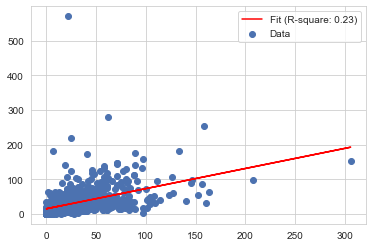

In [38]:
x = sj['station_precip_mm']
y = sj['reanalysis_precip_amt_kg_per_m2']

cleaned_data = pd.concat([x, y], axis=1).dropna()

x_clean = cleaned_data['station_precip_mm'].values.reshape(-1, 1)
y_clean = cleaned_data['reanalysis_precip_amt_kg_per_m2'].values

model = LinearRegression().fit(x_clean, y_clean)

r_squared = model.score(x_clean, y_clean)
print(f'R-squared: {r_squared}')

plt.scatter(x_clean, y_clean, label='Data')
plt.plot(x_clean, model.predict(x_clean),color='r',label=f'Fit (R-square: {r_squared:.2f})')
plt.legend()

plt.savefig('reg_fit1.png', dpi=500)

plt.show()

R-squared: 0.45461992194971224


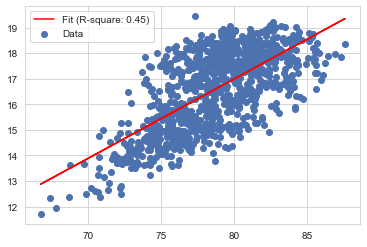

In [39]:
x = sj['reanalysis_relative_humidity_percent']
y = sj['reanalysis_specific_humidity_g_per_kg']

cleaned_data = pd.concat([x, y], axis=1).dropna()

x_clean = cleaned_data['reanalysis_relative_humidity_percent'].values.reshape(-1, 1)
y_clean = cleaned_data['reanalysis_specific_humidity_g_per_kg'].values

model = LinearRegression().fit(x_clean, y_clean)

r_squared = model.score(x_clean, y_clean)
print(f'R-squared: {r_squared}')

plt.scatter(x_clean, y_clean, label='Data')
plt.plot(x_clean, model.predict(x_clean),color='r',label=f'Fit (R-square: {r_squared:.2f})')
plt.legend()

plt.savefig('reg_fit2.png', dpi=500)

plt.show()

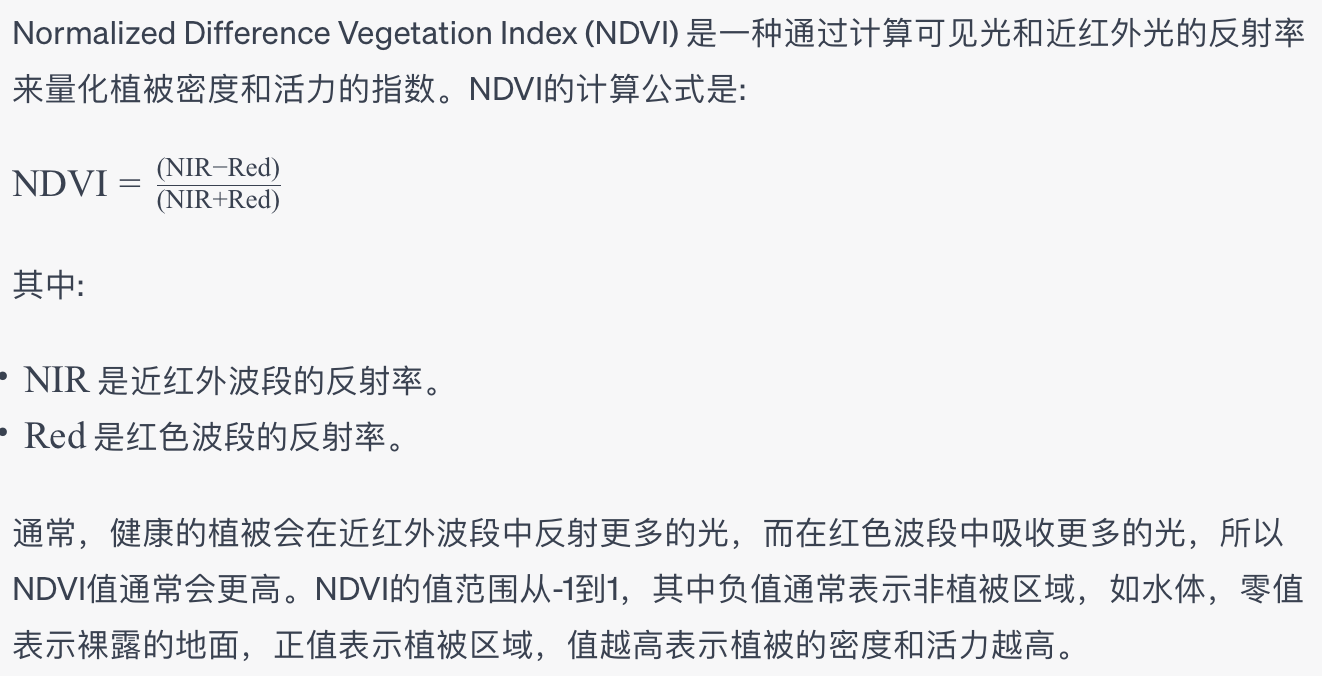

In [28]:
Image("WechatIMG287.jpg")

# Exploratory Data Analysis (EDA) - Phase One

## Descriptive Statistics

In [40]:
summary = sj.describe()
summary.T

,count,mean,std,min,25%,50%,75%,max
weekofyear,936.0,26.503205,15.021909,1.000000,13.750000,26.500000,39.250000,53.000000
ndvi_ne,745.0,0.057925,0.107153,-0.406250,0.004500,0.057700,0.111100,0.493400
ndvi_nw,887.0,0.067469,0.092479,-0.456100,0.016425,0.068075,0.115200,0.437100
ndvi_se,917.0,0.177655,0.057166,-0.015533,0.139283,0.177186,0.212557,0.393129
ndvi_sw,917.0,0.165956,0.056073,-0.063457,0.129157,0.165971,0.202771,0.381420
reanalysis_precip_amt_kg_per_m2,930.0,30.465419,35.628055,0.000000,10.825000,21.300000,37.000000,570.500000
reanalysis_relative_humidity_percent,930.0,78.568181,3.389488,66.735714,76.246071,78.667857,80.963214,87.575714
reanalysis_specific_humidity_g_per_kg,930.0,16.552409,1.560923,11.715714,15.236429,16.845714,17.858571,19.440000
station_avg_temp_c,930.0,27.006528,1.415473,22.842857,25.842857,27.228571,28.185714,30.071429
station_diur_temp_rng_c,930.0,6.757373,0.835993,4.528571,6.200000,6.757143,7.285714,9.914286


In [41]:
variance = sj.var()
print(variance)

weekofyear                                225.657744
ndvi_ne                                     0.011482
ndvi_nw                                     0.008552
ndvi_se                                     0.003268
ndvi_sw                                     0.003144
reanalysis_precip_amt_kg_per_m2          1269.358301
reanalysis_relative_humidity_percent       11.488627
reanalysis_specific_humidity_g_per_kg       2.436481
station_avg_temp_c                          2.003565
station_diur_temp_rng_c                     0.698884
station_max_temp_c                          2.949108
station_min_temp_c                          2.268869
station_precip_mm                         860.003180
total_cases                              2640.045440
reanalysis_dew_point_temp_c                 2.464722
dtype: float64


/var/folders/pj/9y_1xfsd6hgdycw5q9sfcq5w0000gn/T/ipykernel_43117/3722301002.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variance = sj.var()


In [42]:
skewness = sj.skew()
print(skewness)

weekofyear                               0.001282
ndvi_ne                                 -0.016905
ndvi_nw                                 -0.086188
ndvi_se                                  0.215362
ndvi_sw                                  0.146345
reanalysis_precip_amt_kg_per_m2          5.568382
reanalysis_relative_humidity_percent    -0.192060
reanalysis_specific_humidity_g_per_kg   -0.468625
station_avg_temp_c                      -0.309973
station_diur_temp_rng_c                  0.104128
station_max_temp_c                      -0.438909
station_min_temp_c                      -0.391557
station_precip_mm                        2.630498
total_cases                              4.478951
reanalysis_dew_point_temp_c             -0.626015
dtype: float64


/var/folders/pj/9y_1xfsd6hgdycw5q9sfcq5w0000gn/T/ipykernel_43117/1394509435.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skewness = sj.skew()


In [43]:
kurtosis = sj.kurt()
print(kurtosis)

weekofyear                               -1.199105
ndvi_ne                                   2.043667
ndvi_nw                                   2.036564
ndvi_se                                   0.431881
ndvi_sw                                   0.653120
reanalysis_precip_amt_kg_per_m2          62.729650
reanalysis_relative_humidity_percent     -0.072789
reanalysis_specific_humidity_g_per_kg    -0.730868
station_avg_temp_c                       -0.893883
station_diur_temp_rng_c                   0.481478
station_max_temp_c                       -0.521300
station_min_temp_c                       -0.466088
station_precip_mm                        12.785648
total_cases                              25.372135
reanalysis_dew_point_temp_c              -0.393726
dtype: float64


/var/folders/pj/9y_1xfsd6hgdycw5q9sfcq5w0000gn/T/ipykernel_43117/3902502835.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  kurtosis = sj.kurt()


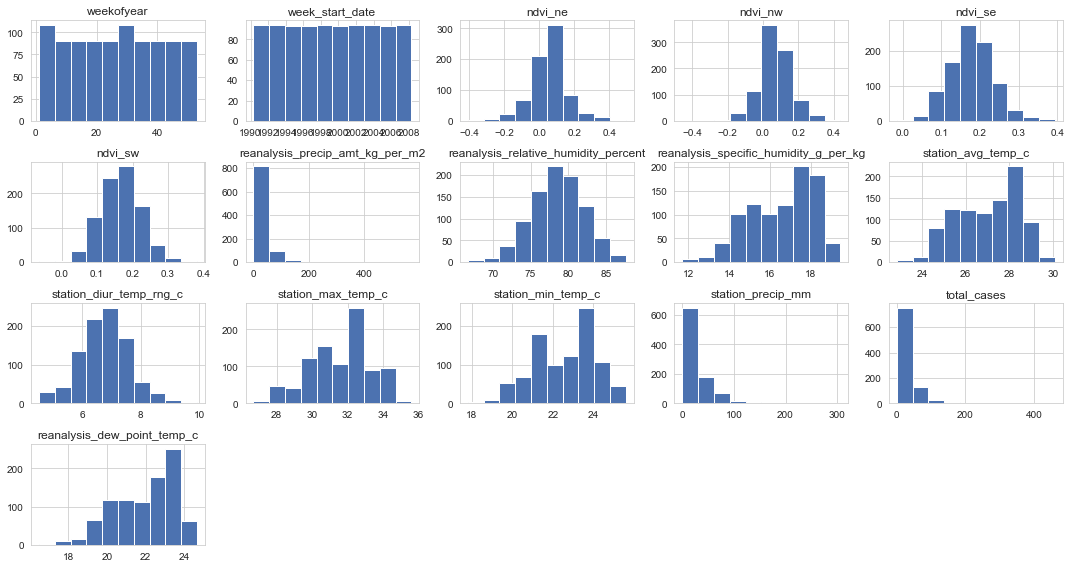

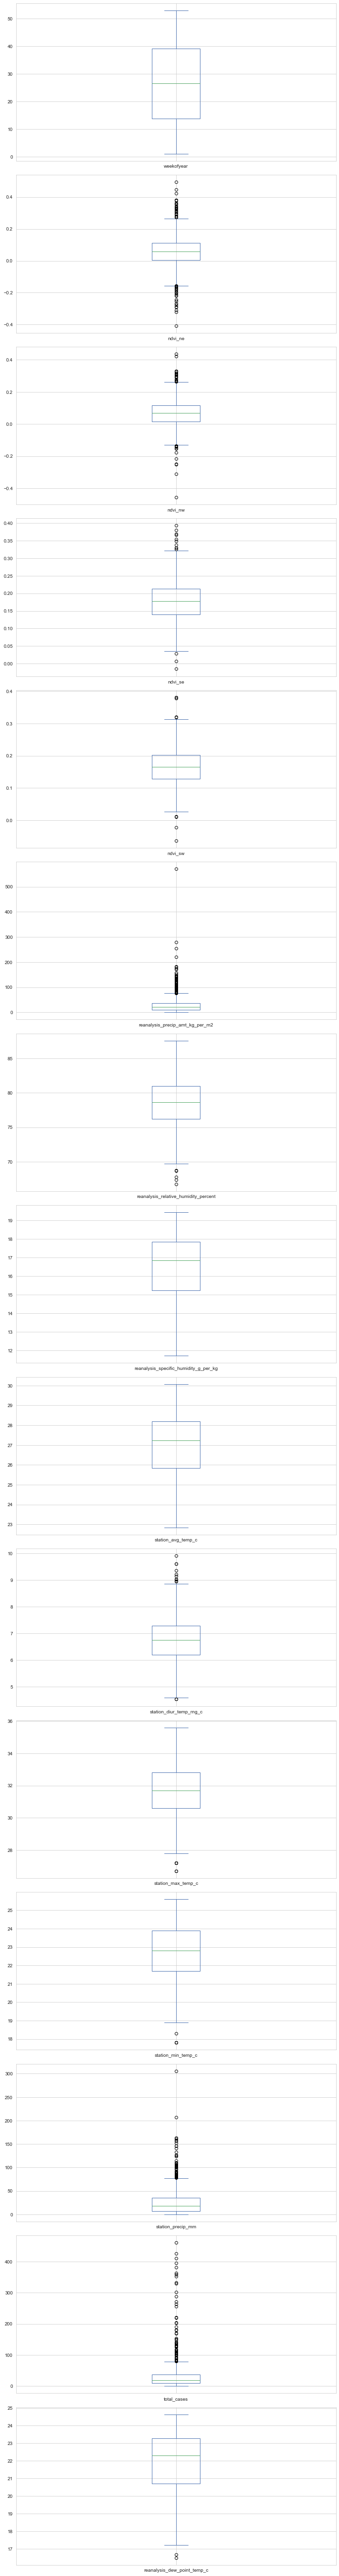

In [44]:
sj.hist(layout=(int(sj.shape[1]/4), 5), figsize=(15, 8))
plt.tight_layout()
plt.show()

sj.plot(kind='box', subplots=True, layout=(sj.shape[1], 1), figsize=(10, sj.shape[1]*5), sharex=False)
plt.tight_layout()
plt.show()

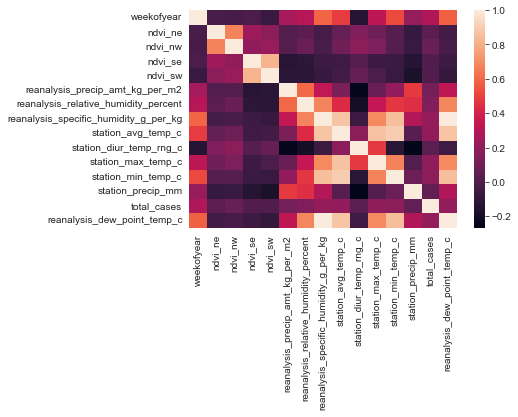

In [45]:
correlation = sj.corr()
sns.heatmap(correlation)
plt.show()

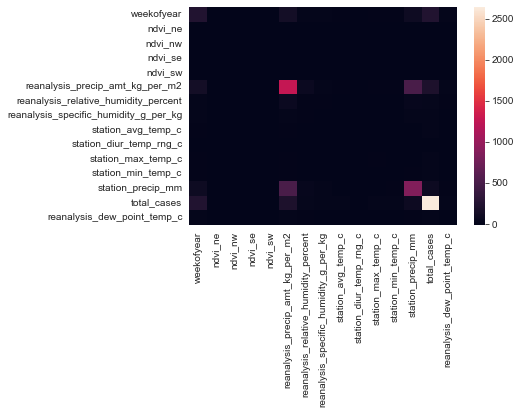

In [46]:
covariance = sj.cov()
sns.heatmap(covariance)
plt.show()

## Visualization

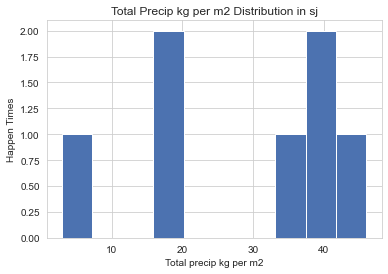

In [47]:
plt.hist(sj[sj['station_precip_mm'] >= 150]['weekofyear'])

plt.title('Total Precip kg per m2 Distribution in sj')
plt.xlabel('Total precip kg per m2')
plt.ylabel('Happen Times')

plt.show()

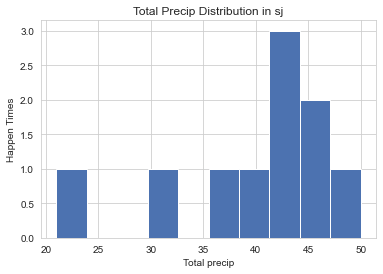

In [48]:
plt.hist(sj[sj['reanalysis_precip_amt_kg_per_m2'] >= 150]['weekofyear'])

plt.title('Total Precip Distribution in sj')
plt.xlabel('Total precip')
plt.ylabel('Happen Times')

plt.show()

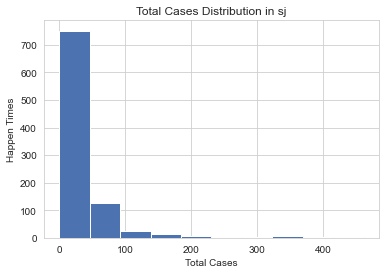

In [49]:
plt.hist(sj['total_cases'])

plt.title('Total Cases Distribution in sj')
plt.xlabel('Total Cases')
plt.ylabel('Happen Times')

plt.show()

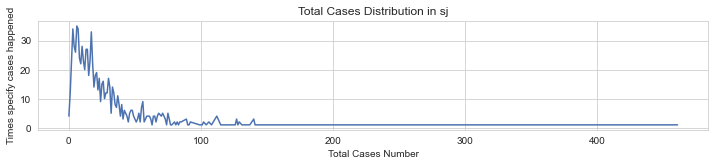

In [50]:
l_n_c = list(sj['total_cases'].unique())
l_n_c.sort()

l_n = []
for i in l_n_c:
    l_n.append(sj[sj['total_cases'] == i]['total_cases'].count())
    
plt.figure(figsize=(12,2))
plt.plot(l_n_c, l_n)

plt.title('Total Cases Distribution in sj')
plt.xlabel('Total Cases Number')
plt.ylabel('Times specify cases happened')

plt.show()

In [51]:
df_n = pd.DataFrame([l_n_c,l_n]).T
df_n.columns = ['Cases count', 'Happen times']
df_n[df_n['Happen times'] == 5]

,Cases count,Happen times
32,32,5
43,43,5
46,46,5
53,53,5
67,68,5
69,71,5
73,75,5


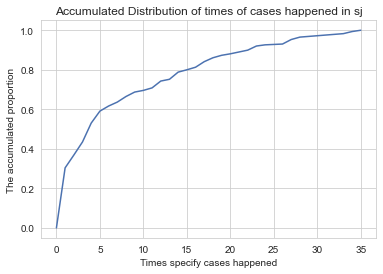

In [53]:
sum_case_num = sj['total_cases'].sum()

n_list = list(df_n['Happen times'].unique())
n_list.sort()

acc_l = []

for i in n_list:
    acc_l.append(df_n[df_n['Happen times'] == i]['Cases count'].sum()*i/sum_case_num)
    
for k in range(1,len(acc_l)):
    acc_l[k] = acc_l[k] + acc_l[k-1]

n_list.insert(0,0)
acc_l.insert(0,0)

df_acc = pd.DataFrame([n_list, acc_l])

plt.plot(n_list, acc_l)

plt.title('Accumulated Distribution of times of cases happened in sj')
plt.xlabel('Times specify cases happened')
plt.ylabel('The accumulated proportion')

plt.show()

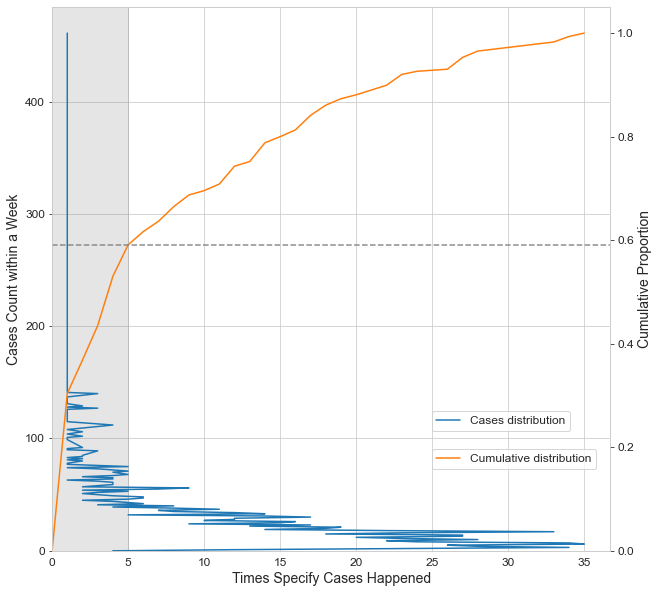

In [120]:
sns.set_style("whitegrid")
sns.set_palette("deep")

fig, ax1 = plt.subplots(figsize=(10, 10))

colors = sns.color_palette()

ax1.plot(l_n, l_n_c, color='#1f77b4', label='Cases distribution')
ax1.set_ylabel('Cases Count within a Week', fontsize=14)
ax1.set_xlabel('Times Specify Cases Happened', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.legend(loc=(0.68,0.22), fontsize=12)
ax1.set_xlim(left=0)
ax1.set_ylim(bottom=0)

ax2 = ax1.twinx()

ax2.plot(n_list, acc_l, color='#ff7f0e', label='Cumulative distribution')
ax2.set_ylabel('Cumulative Proportion', fontsize=14)
ax2.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='x', labelsize=12)
ax2.legend(loc=(0.68,0.15), fontsize=12)
ax2.grid(False)
ax2.set_xlim(left=0)
ax2.set_ylim(bottom=0)

xi = 5
y1i = 32
y2i = 0.590911

ax2.axhline(y2i, xmin=0, xmax=35, linestyle='--', color='grey', alpha=0.9)
#ax1.axhline(y1i, xmin=0, xmax=35, linestyle='--', color='grey', alpha=0.8)
ax1.fill_between([0,xi], y1=0, y2=484, color='grey', alpha=0.2)
#ax2.fill_between([0,35], y1=y2i, y2=1, color='grey', alpha=0.2)


#plt.title("Prevalent Threshold", fontsize=18)

plt.show()
                        
fig.savefig('Prevalent threshold.png', dpi=500)

## Missing Value Analysis

In [56]:
print(sj.isnull().sum())

weekofyear                                 0
week_start_date                            0
ndvi_ne                                  191
ndvi_nw                                   49
ndvi_se                                   19
ndvi_sw                                   19
reanalysis_precip_amt_kg_per_m2            6
reanalysis_relative_humidity_percent       6
reanalysis_specific_humidity_g_per_kg      6
station_avg_temp_c                         6
station_diur_temp_rng_c                    6
station_max_temp_c                         6
station_min_temp_c                         6
station_precip_mm                          6
total_cases                                0
reanalysis_dew_point_temp_c                6
dtype: int64


# Data Preprocessing

## Handling Missing Values

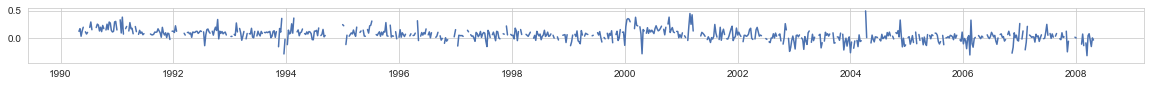

In [57]:
plt.figure(figsize = (20,1))
plt.plot(sj['week_start_date'],sj['ndvi_ne'])
plt.show()

In [58]:
dne_sj = sj[sj['ndvi_ne'].isnull()][['week_start_date','weekofyear','ndvi_ne']]

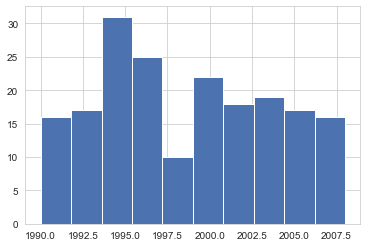

In [59]:
plt.hist(dne_sj['week_start_date'].dt.year)
plt.show()

In [60]:
filled_data = sj['ndvi_ne'].interpolate(method='linear')

/var/folders/pj/9y_1xfsd6hgdycw5q9sfcq5w0000gn/T/ipykernel_43117/1312620438.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(filled_data, model='additive', freq=52)


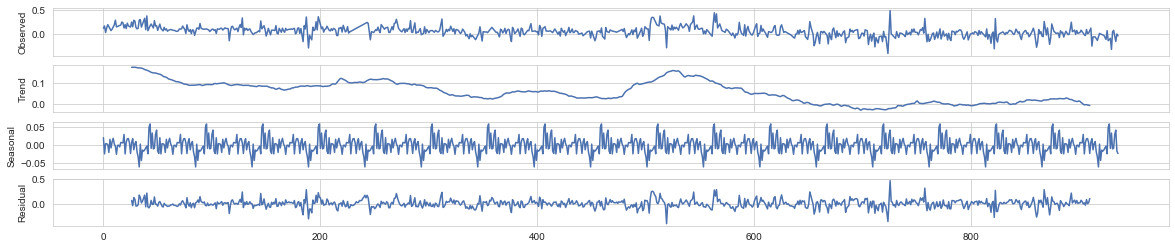

In [61]:
result = seasonal_decompose(filled_data, model='additive', freq=52)
fig, axes = plt.subplots(4, 1, figsize=(20, 4), sharex=True)
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

In [62]:
sj['ndvi_ne'] = sj['ndvi_ne'].interpolate(method='linear')
sj['ndvi_nw'] = sj['ndvi_nw'].interpolate(method='linear')
sj['ndvi_se'] = sj['ndvi_se'].interpolate(method='linear')
sj['ndvi_sw'] = sj['ndvi_sw'].interpolate(method='linear')

In [63]:
print(sj.isnull().sum())

weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
reanalysis_precip_amt_kg_per_m2          6
reanalysis_relative_humidity_percent     6
reanalysis_specific_humidity_g_per_kg    6
station_avg_temp_c                       6
station_diur_temp_rng_c                  6
station_max_temp_c                       6
station_min_temp_c                       6
station_precip_mm                        6
total_cases                              0
reanalysis_dew_point_temp_c              6
dtype: int64


In [64]:
mean_fill_l = ['reanalysis_relative_humidity_percent','reanalysis_specific_humidity_g_per_kg',
  'station_avg_temp_c','station_diur_temp_rng_c','station_max_temp_c','station_min_temp_c',
  'reanalysis_dew_point_temp_c']

for i in range(len(mean_fill_l)):
    sj[mean_fill_l[i]].fillna(sj[mean_fill_l[i]].mean(),inplace = True)

In [65]:
print(sj.isnull().sum())

weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
reanalysis_precip_amt_kg_per_m2          6
reanalysis_relative_humidity_percent     0
reanalysis_specific_humidity_g_per_kg    0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        6
total_cases                              0
reanalysis_dew_point_temp_c              0
dtype: int64


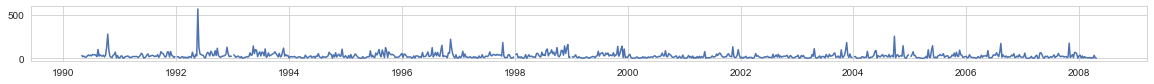

In [66]:
plt.figure(figsize = (20,1))
plt.plot(sj['week_start_date'],sj['reanalysis_precip_amt_kg_per_m2'])
plt.show()

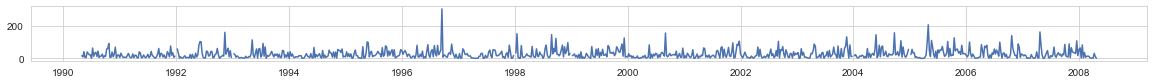

In [67]:
plt.figure(figsize = (20,1))
plt.plot(sj['week_start_date'],sj['station_precip_mm'])
plt.show()

In [68]:
sj['reanalysis_precip_amt_kg_per_m2'] = sj['reanalysis_precip_amt_kg_per_m2'].interpolate(method='linear')
sj['station_precip_mm'] = sj['station_precip_mm'].interpolate(method='linear')

In [69]:
print(sj.isnull().sum())

weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_specific_humidity_g_per_kg    0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
total_cases                              0
reanalysis_dew_point_temp_c              0
dtype: int64


## Dataset Splitting

In [70]:
sj.set_index('week_start_date', inplace=True)

In [71]:
train_size = int(len(sj) * 0.7)
val_size = int(len(sj) * 0.1)

In [72]:
train = sj.iloc[:train_size]
val = sj.iloc[train_size:train_size + val_size]
test = sj.iloc[train_size + val_size:]

In [73]:
train

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,reanalysis_dew_point_temp_c
week_start_date,,,,,,,,,,,,,,,
1990-04-30,18,0.122600,0.103725,0.198483,0.177617,32.00,73.365714,14.012857,25.442857,6.900000,29.4,20.0,16.0,4,19.264286
1990-05-07,19,0.169900,0.142175,0.162357,0.155486,17.94,77.368571,15.372857,26.714286,6.371429,31.7,22.2,8.6,5,20.801429
1990-05-14,20,0.032250,0.172967,0.157200,0.170843,26.10,82.052857,16.848571,26.714286,6.485714,32.2,22.8,41.4,4,22.284286
1990-05-21,21,0.128633,0.245067,0.227557,0.235886,13.90,80.337143,16.672857,27.471429,6.771429,33.3,23.3,4.0,3,22.160000
1990-05-28,22,0.196200,0.262200,0.251200,0.247340,12.20,80.460000,17.210000,28.942857,9.371429,35.0,23.9,5.8,6,22.671429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-10-29,44,0.007350,-0.025450,0.199343,0.179543,34.70,77.620000,17.688571,27.542857,6.571429,31.7,23.3,31.3,10,23.090000
2002-11-05,45,0.261400,0.110220,0.291800,0.318500,9.50,76.167143,17.265714,27.385714,6.542857,31.1,23.3,8.4,6,22.702857
2002-11-12,46,0.147833,-0.003125,0.278157,0.247729,7.60,73.781429,16.818571,27.314286,7.014286,31.1,22.8,3.8,13,22.297143


# Feature Engineering - Phase One

## Creating Lagged Variables

In [74]:
def create_lagged_vars(df, columns, lags):
    for column in columns:
        for lag in lags:
            if column not in df:
                raise ValueError(f"Column {column} not found in DataFrame")
            df[f'{column}_lag{lag}'] = df[column].shift(lag)
    return df.dropna()

In [75]:
lags = [1, 2, 4, 8, 12]

In [76]:
columns = ['station_avg_temp_c', 'station_precip_mm', 'total_cases']a

In [77]:
train = create_lagged_vars(train, columns, lags)

/var/folders/pj/9y_1xfsd6hgdycw5q9sfcq5w0000gn/T/ipykernel_43117/2525416368.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column}_lag{lag}'] = df[column].shift(lag)


In [78]:
train

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,...,station_precip_mm_lag1,station_precip_mm_lag2,station_precip_mm_lag4,station_precip_mm_lag8,station_precip_mm_lag12,total_cases_lag1,total_cases_lag2,total_cases_lag4,total_cases_lag8,total_cases_lag12
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-07-23,30,0.150567,0.171700,0.226900,0.214557,42.53,80.742857,17.341429,28.114286,6.357143,...,12.2,63.7,21.1,5.8,16.0,2.0,8.0,10.0,6.0,4.0
1990-07-30,31,0.160483,0.247150,0.379700,0.381357,34.60,80.584286,17.594286,28.242857,8.085714,...,32.6,12.2,1.1,39.1,8.6,6.0,2.0,6.0,2.0,5.0
1990-08-06,32,0.170400,0.064333,0.164443,0.138857,20.00,79.650000,17.950000,28.200000,7.557143,...,37.6,32.6,63.7,29.7,41.4,17.0,6.0,8.0,4.0,4.0
1990-08-13,33,0.180317,0.128033,0.206957,0.168243,101.90,84.178571,18.515714,28.042857,6.685714,...,11.4,37.6,12.2,21.1,4.0,23.0,17.0,2.0,5.0,3.0
1990-08-20,34,0.190233,0.168800,0.167657,0.172286,25.90,80.947143,18.174286,28.342857,7.014286,...,44.7,11.4,32.6,21.1,5.8,13.0,23.0,6.0,10.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-10-29,44,0.007350,-0.025450,0.199343,0.179543,34.70,77.620000,17.688571,27.542857,6.571429,...,53.3,6.1,72.7,105.0,3.6,5.0,5.0,7.0,7.0,4.0
2002-11-05,45,0.261400,0.110220,0.291800,0.318500,9.50,76.167143,17.265714,27.385714,6.542857,...,31.3,53.3,26.0,2.3,13.6,10.0,5.0,9.0,6.0,7.0
2002-11-12,46,0.147833,-0.003125,0.278157,0.247729,7.60,73.781429,16.818571,27.314286,7.014286,...,8.4,31.3,6.1,53.2,48.1,6.0,10.0,5.0,4.0,6.0


## Interaction Features

In [79]:
def create_interaction_vars(df, columns1, columns2):
    for column1 in columns1:
        for column2 in columns2:
            if column1 not in df or column2 not in df:
                raise ValueError(f"Column {column1} or {column2} not found in DataFrame")
            if not (pd.api.types.is_numeric_dtype(df[column1]) and pd.api.types.is_numeric_dtype(df[column2])):
                raise TypeError(f"Columns {column1} and {column2} must be numeric")
            new_column_name = f'{column1}*{column2}'
            if new_column_name in df:
                raise ValueError(f"Column {new_column_name} already exists in DataFrame")
            df[f'{column1}*{column2}'] = df[column1]*df[column2]
    return df

In [80]:
train = create_interaction_vars(train, ['station_max_temp_c', 'station_min_temp_c', 'station_avg_temp_c',
                                       'station_diur_temp_rng_c']
                                , ['reanalysis_precip_amt_kg_per_m2', 'station_precip_mm'])

/var/folders/pj/9y_1xfsd6hgdycw5q9sfcq5w0000gn/T/ipykernel_43117/4234690929.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column1}*{column2}'] = df[column1]*df[column2]


In [81]:
train

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,...,total_cases_lag8,total_cases_lag12,station_max_temp_c*reanalysis_precip_amt_kg_per_m2,station_max_temp_c*station_precip_mm,station_min_temp_c*reanalysis_precip_amt_kg_per_m2,station_min_temp_c*station_precip_mm,station_avg_temp_c*reanalysis_precip_amt_kg_per_m2,station_avg_temp_c*station_precip_mm,station_diur_temp_rng_c*reanalysis_precip_amt_kg_per_m2,station_diur_temp_rng_c*station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-07-23,30,0.150567,0.171700,0.226900,0.214557,42.53,80.742857,17.341429,28.114286,6.357143,...,6.0,4.0,1348.201,1033.42,969.684,743.28,1195.700571,916.525714,270.369286,207.242857
1990-07-30,31,0.160483,0.247150,0.379700,0.381357,34.60,80.584286,17.594286,28.242857,8.085714,...,2.0,5.0,1190.240,1293.44,788.880,857.28,977.202857,1061.931429,279.765714,304.022857
1990-08-06,32,0.170400,0.064333,0.164443,0.138857,20.00,79.650000,17.950000,28.200000,7.557143,...,4.0,4.0,666.000,379.62,466.000,265.62,564.000000,321.480000,151.142857,86.151429
1990-08-13,33,0.180317,0.128033,0.206957,0.168243,101.90,84.178571,18.515714,28.042857,6.685714,...,5.0,3.0,3342.320,1466.16,2323.320,1019.16,2857.567143,1253.515714,681.274286,298.851429
1990-08-20,34,0.190233,0.168800,0.167657,0.172286,25.90,80.947143,18.174286,28.342857,7.014286,...,10.0,6.0,862.470,179.82,603.470,125.82,734.080000,153.051429,181.670000,37.877143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-10-29,44,0.007350,-0.025450,0.199343,0.179543,34.70,77.620000,17.688571,27.542857,6.571429,...,7.0,4.0,1099.990,992.21,808.510,729.29,955.737143,862.091429,228.028571,205.685714
2002-11-05,45,0.261400,0.110220,0.291800,0.318500,9.50,76.167143,17.265714,27.385714,6.542857,...,6.0,7.0,295.450,261.24,221.350,195.72,260.164286,230.040000,62.157143,54.960000
2002-11-12,46,0.147833,-0.003125,0.278157,0.247729,7.60,73.781429,16.818571,27.314286,7.014286,...,4.0,6.0,236.360,118.18,173.280,86.64,207.588571,103.794286,53.308571,26.654286


# Exploratory Data Analysis (EDA) - Phase Two

## Correlation Analysis

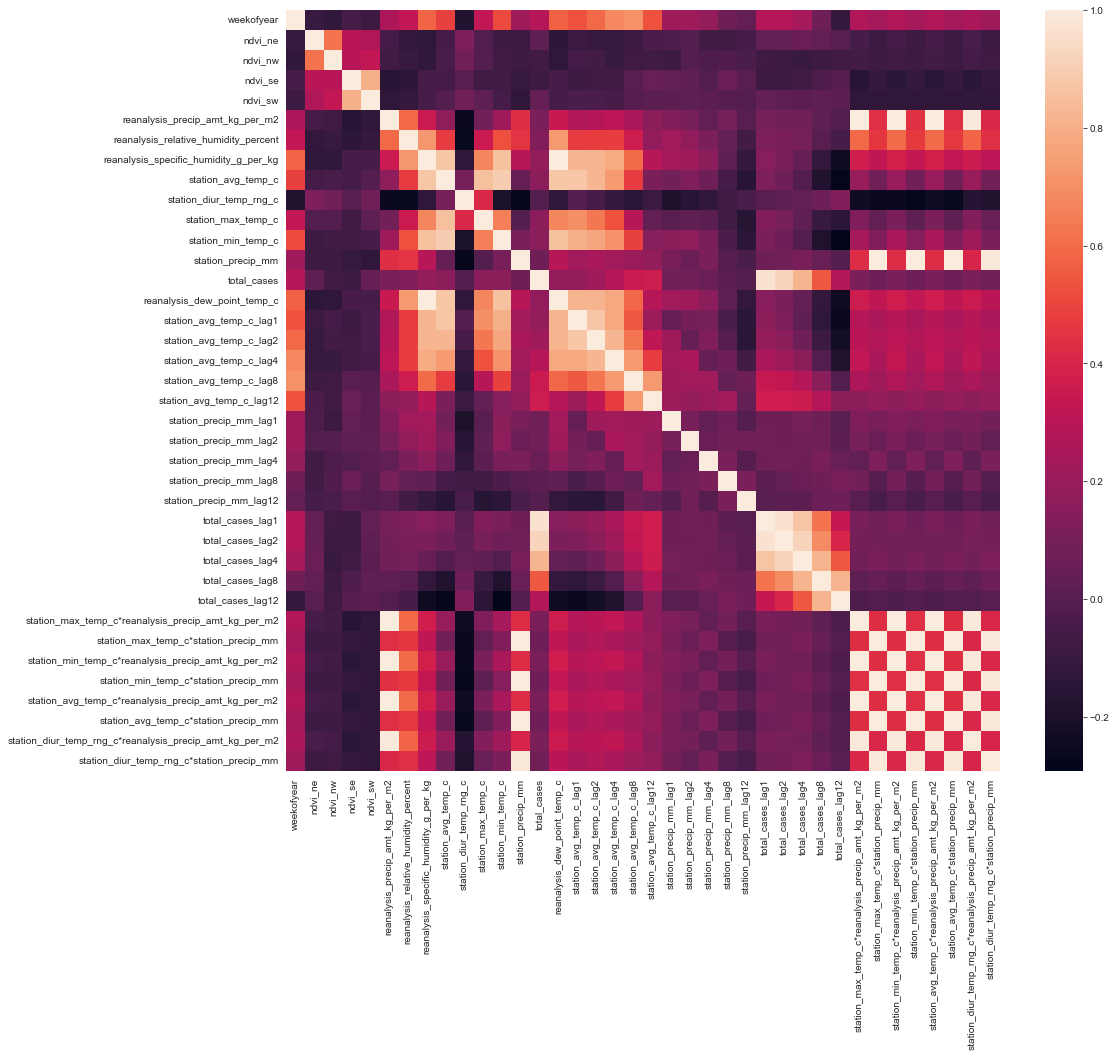

In [82]:
plt.figure(figsize=(16,14))
sns.heatmap(train.corr())
plt.show()

## Pattern Recognition

/var/folders/pj/9y_1xfsd6hgdycw5q9sfcq5w0000gn/T/ipykernel_43117/324424720.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(train['total_cases'], model='additive', freq=52)


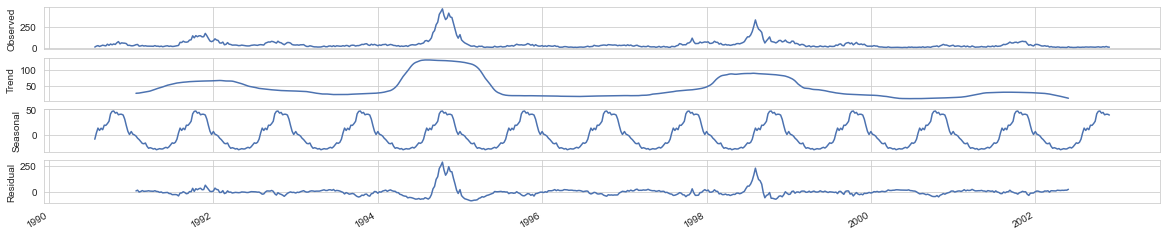

In [87]:
result = seasonal_decompose(train['total_cases'], model='additive', freq=52)
fig, axes = plt.subplots(4, 1, figsize=(20, 4), sharex=True)
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')
axes[3].set_xlabel('')

fig.savefig("Seasonal Trend.png",dpi = 500)
plt.show()

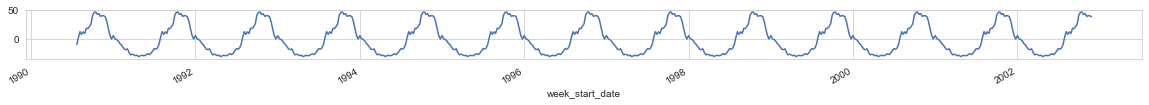

In [88]:
plt.figure(figsize=(20,1))
result.seasonal.plot()
plt.show()

# Feature Engineering - Phase Two

## Temporal Features

In [89]:
one_year_seasonal = result.seasonal.iloc[:52].reset_index(drop=True)
one_year_seasonal = one_year_seasonal.append(pd.Series(one_year_seasonal.iloc[0]), ignore_index=True)

def map_week_to_seasonal(week_of_year):
    index = (week_of_year - 30) % 52
    return one_year_seasonal[index]

train['seasonal_feature'] = train['weekofyear'].apply(map_week_to_seasonal)

/var/folders/pj/9y_1xfsd6hgdycw5q9sfcq5w0000gn/T/ipykernel_43117/3925559633.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['seasonal_feature'] = train['weekofyear'].apply(map_week_to_seasonal)


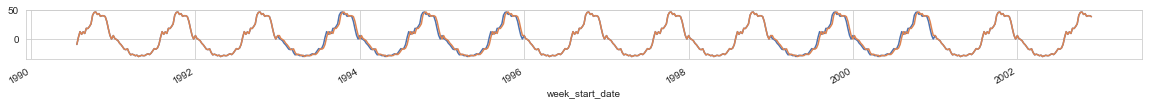

In [90]:
plt.figure(figsize=(20,1))
result.seasonal.plot()
plt.plot(train.index,train['seasonal_feature'])

plt.show()

## Feature Selection

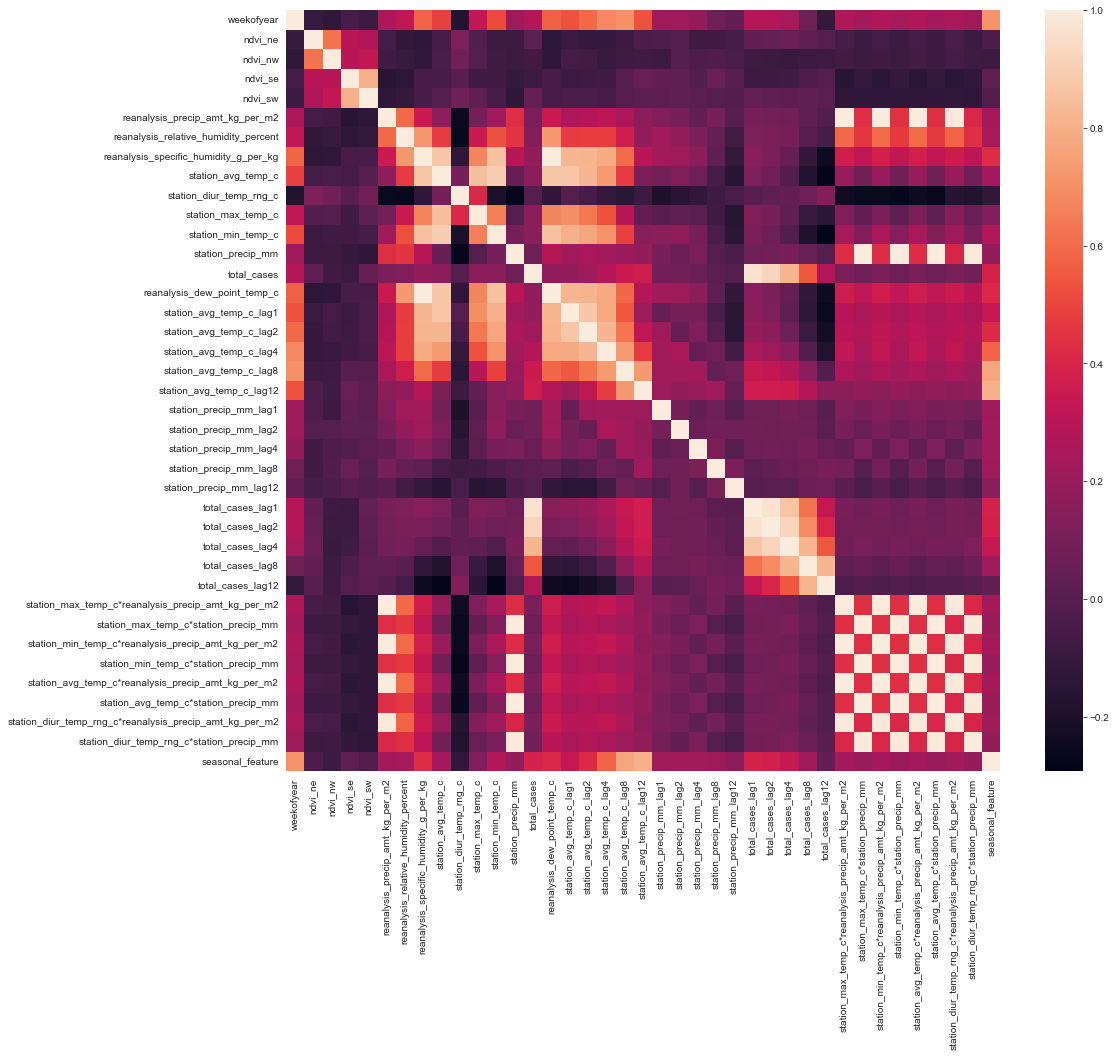

In [91]:
plt.figure(figsize=(16,14))
sns.heatmap(train.corr())
plt.show()

In [92]:
val = create_lagged_vars(val, columns, lags)
val = create_interaction_vars(val, ['station_max_temp_c', 'station_min_temp_c', 'station_avg_temp_c',
                                       'station_diur_temp_rng_c']
                                , ['reanalysis_precip_amt_kg_per_m2', 'station_precip_mm'])
val['seasonal_feature'] = val['weekofyear'].apply(map_week_to_seasonal)

/var/folders/pj/9y_1xfsd6hgdycw5q9sfcq5w0000gn/T/ipykernel_43117/2525416368.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column}_lag{lag}'] = df[column].shift(lag)
/var/folders/pj/9y_1xfsd6hgdycw5q9sfcq5w0000gn/T/ipykernel_43117/4234690929.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column1}*{column2}'] = df[column1]*df[column2]
/var/folders/pj/9y_1xfsd6hgdycw5q9sfcq5w0000gn/T/ipykernel_43117/1613406761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [93]:
val

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,...,total_cases_lag12,station_max_temp_c*reanalysis_precip_amt_kg_per_m2,station_max_temp_c*station_precip_mm,station_min_temp_c*reanalysis_precip_amt_kg_per_m2,station_min_temp_c*station_precip_mm,station_avg_temp_c*reanalysis_precip_amt_kg_per_m2,station_avg_temp_c*station_precip_mm,station_diur_temp_rng_c*reanalysis_precip_amt_kg_per_m2,station_diur_temp_rng_c*station_precip_mm,seasonal_feature
week_start_date,,,,,,,,,,,,,,,,,,,,,
2003-02-26,9,-0.030467,-0.000100,0.128633,0.156117,7.20,74.734286,15.194286,25.628571,6.742857,...,5.0,216.000,246.00,151.920,173.02,184.525714,210.154286,48.548571,55.291429,-18.242326
2003-03-05,10,-0.206350,-0.141000,0.322186,0.299829,0.50,72.690000,14.872857,25.285714,8.042857,...,9.0,14.700,149.94,10.300,105.06,12.642857,128.957143,4.021429,41.018571,-16.793608
2003-03-12,11,0.025350,0.048100,0.101843,0.136529,2.70,74.608571,15.490000,26.542857,7.385714,...,3.0,83.970,80.86,58.590,56.42,71.665714,69.011429,19.941429,19.202857,-23.268768
2003-03-19,12,-0.052033,0.014220,0.155643,0.182271,1.80,72.135714,14.884286,26.457143,7.928571,...,6.0,55.980,40.43,39.060,28.21,47.622857,34.394286,14.271429,10.307143,-27.228704
2003-03-26,13,-0.116900,-0.091575,0.152729,0.186771,7.30,74.325714,15.221429,26.928571,7.057143,...,11.0,235.060,64.40,166.440,45.60,196.578571,53.857143,51.517143,14.114286,-26.098095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-08-12,33,0.037400,0.108400,0.125300,0.177414,14.10,76.171429,17.818571,28.942857,7.228571,...,3.0,477.990,355.95,344.040,256.20,408.094286,303.900000,101.922857,75.900000,8.234000
2004-08-19,34,-0.016400,-0.021875,0.181600,0.170600,44.40,81.264286,18.774286,29.000000,6.314286,...,12.0,1429.680,911.26,1083.360,690.52,1287.600000,820.700000,280.354286,178.694286,12.602881
2004-08-26,35,0.099600,0.063300,0.100657,0.109429,13.50,79.684286,18.531429,29.057143,6.485714,...,13.0,449.550,685.98,337.500,515.00,392.271429,598.577143,87.557143,133.605714,9.701657


In [94]:
X_train = train.drop('total_cases', axis=1)
y_train = train['total_cases']

X_val = val.drop('total_cases', axis=1)
y_val = val['total_cases'] 

In [95]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [96]:
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)

LassoCV(cv=5, random_state=42)

In [97]:
feature_importance = lasso.coef_

In [98]:
feature_importance[24]

57.789111443525535

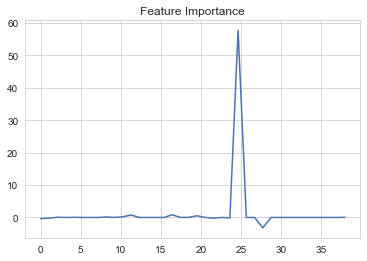

In [99]:
plt.plot(np.linspace(0,38,38),feature_importance)

plt.title("Feature Importance")

plt.show()

In [100]:
X_train.columns[24]

'total_cases_lag1'

In [101]:
important_features = np.where(feature_importance != 0)[0]
print(f'Important features: {important_features}')

Important features: [ 0  1  2  4  8 10 11 16 18 19 21 23 24 27 37]


In [102]:
X_train_important = X_train.iloc[:, important_features]
X_val_important = X_val.iloc[:, important_features]

In [103]:
lasso.fit(X_train_important, y_train)
y_pred = lasso.predict(X_val_important)
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 32.96144702701446


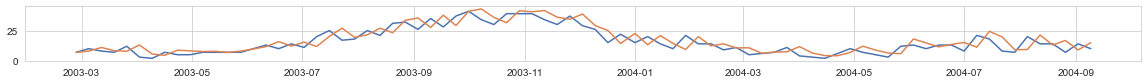

In [104]:
plt.figure(figsize=(20,1))
plt.plot(y_val.index,y_val)
plt.plot(y_val.index,y_pred)

In [105]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [106]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [107]:
y_pred = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 31.465933333333336


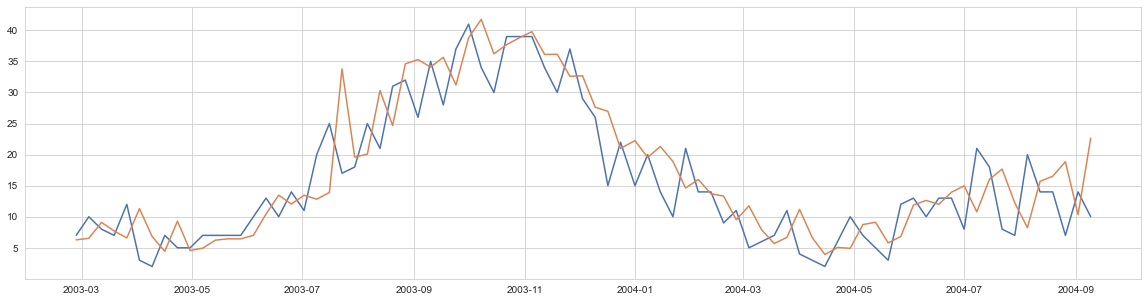

In [108]:
plt.figure(figsize=(20,5))
plt.plot(y_val.index,y_val)
plt.plot(y_val.index,y_pred)

In [109]:
sfm = SelectFromModel(rf, prefit=True)

In [110]:
X_train_selected = sfm.transform(X_train)
X_val_selected = sfm.transform(X_val)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [111]:
print(f'Number of features selected: {X_train_selected.shape[1]}')

Number of features selected: 1


In [112]:
# 1 feature is not enough
median = np.median(rf.feature_importances_)
sfm = SelectFromModel(rf, threshold=median, prefit=True)
X_train_selected = sfm.transform(X_train)
X_val_selected = sfm.transform(X_val)

selected_features = np.array(X_train.columns)[sfm.get_support()]
print(f'Number of features selected: {X_train_selected.shape[1]}')
print(f'Selected features: {selected_features}')

Number of features selected: 19
Selected features: ['weekofyear' 'ndvi_nw' 'ndvi_se' 'reanalysis_specific_humidity_g_per_kg'
 'station_diur_temp_rng_c' 'reanalysis_dew_point_temp_c'
 'station_avg_temp_c_lag2' 'station_avg_temp_c_lag4'
 'station_avg_temp_c_lag8' 'station_avg_temp_c_lag12'
 'station_precip_mm_lag1' 'station_precip_mm_lag4' 'total_cases_lag1'
 'total_cases_lag2' 'total_cases_lag4' 'total_cases_lag8'
 'total_cases_lag12'
 'station_diur_temp_rng_c*reanalysis_precip_amt_kg_per_m2'
 'seasonal_feature']


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Mean Squared Error: 31.498686419753092


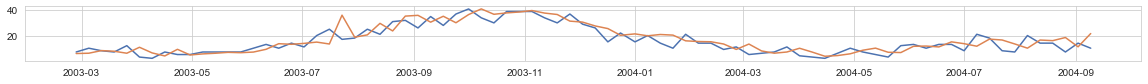

In [113]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_selected, y_train)
y_pred = rf.predict(X_val_selected)
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error: {mse}')

plt.figure(figsize=(20,1))
plt.plot(y_val.index,y_val)
plt.plot(y_val.index,y_pred)

# Model Development

## Machine Learning Model

In [114]:
X_train, X_val, y_train, y_val = X_train[selected_features], X_val[selected_features], y_train, y_val

In [115]:
models = [
    RandomForestRegressor(),
    MLPRegressor(),
    SVR(),
    KernelRidge(),
    GaussianProcessRegressor(),
    GradientBoostingRegressor(),
    TPOTRegressor(generations=5, population_size=50, verbosity=2)
]

for model in models:
    model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -232.06037277802557

Generation 2 - Current best internal CV score: -229.92917107041632

Generation 3 - Current best internal CV score: -229.92917107041632

Generation 4 - Current best internal CV score: -229.92917107041632

Generation 5 - Current best internal CV score: -229.92917107041632

Best pipeline: LinearSVR(input_matrix, C=0.001, dual=True, epsilon=0.001, loss=squared_epsilon_insensitive, tol=1e-05)


In [116]:
predictions = np.column_stack([
    model.predict(X_val) for model in models
])

In [117]:
predictions = pd.DataFrame(predictions, columns = ['RandomForestRegressor',
    'MLPRegressor',
    'SVR',
    'KernelRidge',
    'GaussianProcessRegressor',
    'GradientBoostingRegressor',
    'TPOTRegressor'])

## Bayesian Methods

In [118]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=7)
    sigma = pm.HalfNormal('sigma', sigma=10)

    mu = alpha + tt.dot(predictions, beta)
    observed = pm.Normal('observed', mu=mu, sigma=sigma, observed=y_val)
    
    trace = pm.sample(2000, tune=1000)

alpha_post = np.mean(trace['alpha'])
beta_post = np.mean(trace['beta'], axis=0)

final_prediction = alpha_post + np.dot(predictions.values, beta_post)
ci_lower, ci_upper = np.percentile(final_prediction, [2.5, 97.5])

/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 45 seconds.
There were 768 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6724059590708447, but should be close to 0.8. Try to increase the number of tuning steps.
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [121]:
prob_greater_than_32 = np.mean(final_prediction > 32)

# Model Evaluation and Tuning

## Cross-Validation

In [122]:
alpha_samples = trace['alpha']
beta_samples = trace['beta']

In [123]:
ensemble_predictions_samples = np.array([
    alpha_sample + np.dot(predictions.values, beta_sample)
    for alpha_sample, beta_sample in zip(alpha_samples, beta_samples)
])

ci_lower, ci_upper = np.percentile(ensemble_predictions_samples, [2.5, 97.5], axis=0)

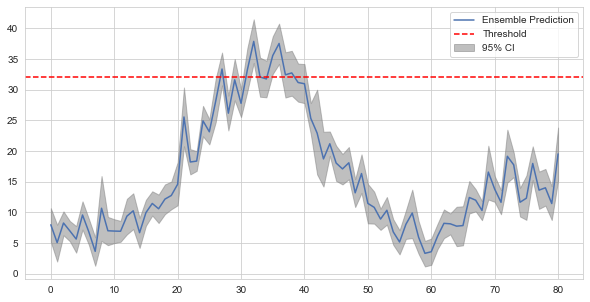

In [125]:
plt.figure(figsize=(10, 5))
plt.plot(final_prediction, label='Ensemble Prediction')
plt.fill_between(np.arange(len(final_prediction)), ci_lower, ci_upper, color='gray', alpha=0.5, label='95% CI')
plt.axhline(y=32, color='red', linestyle='--', label='Threshold')
plt.legend()

plt.savefig("pred_with_interval",dpi=500)

plt.show()

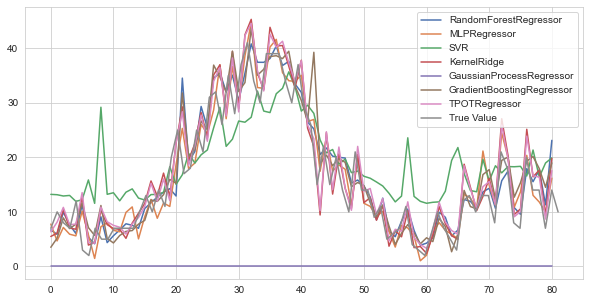

In [126]:
plt.figure(figsize=(10, 5))
plt.plot(predictions, label=predictions.columns)

plt.plot(np.linspace(0,81,81),y_val, label='True Value')

plt.legend()

plt.savefig("diff_models",dpi=500)

plt.show()

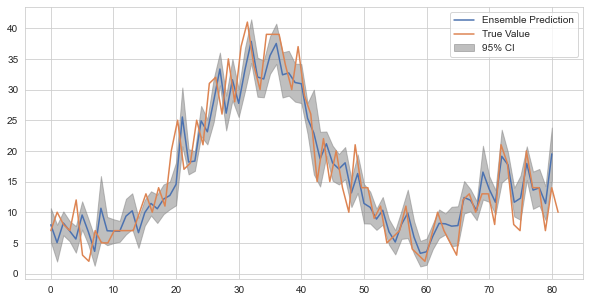

In [127]:
plt.figure(figsize=(10, 5))
plt.plot(final_prediction, label='Ensemble Prediction')
plt.fill_between(np.arange(len(final_prediction)), ci_lower, ci_upper, color='gray', alpha=0.5, label='95% CI')

plt.plot(np.linspace(0,81,81),y_val, label='True Value')

plt.legend()

plt.savefig("true_pred",dpi=500)

plt.show()

In [128]:
mse = mean_squared_error(y_val, final_prediction)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 23.958795417150448


## Tuning

In [129]:
models = [
    RandomForestRegressor(),
    MLPRegressor(),
    KernelRidge(),
    GradientBoostingRegressor(),
    TPOTRegressor(generations=5, population_size=50, verbosity=2)
]

for model in models:
    model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -231.7134919992869

Generation 2 - Current best internal CV score: -231.7134919992869

Generation 3 - Current best internal CV score: -227.3295044655062

Generation 4 - Current best internal CV score: -227.3295044655062

Generation 5 - Current best internal CV score: -224.6685014089629

Best pipeline: RidgeCV(SelectPercentile(input_matrix, percentile=10))


In [130]:
predictions = np.column_stack([
    model.predict(X_val) for model in models
])

In [131]:
predictions = pd.DataFrame(predictions, columns = ['RandomForestRegressor',
    'MLPRegressor',
    'KernelRidge',
    'GradientBoostingRegressor',
    'TPOTRegressor'])

In [132]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=5)
    sigma = pm.HalfNormal('sigma', sigma=10)

    mu = alpha + tt.dot(predictions, beta)
    observed = pm.Normal('observed', mu=mu, sigma=sigma, observed=y_val)
    
    trace = pm.sample(2000, tune=1000)

alpha_post = np.mean(trace['alpha'])
beta_post = np.mean(trace['beta'], axis=0)

final_prediction = alpha_post + np.dot(predictions.values, beta_post)
ci_lower, ci_upper = np.percentile(final_prediction, [2.5, 97.5])

/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 172 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


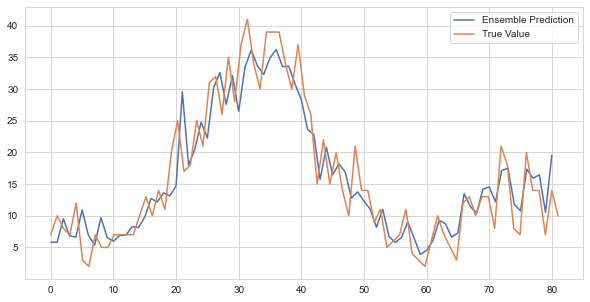

In [133]:
plt.figure(figsize=(10, 5))
plt.plot(final_prediction, label='Ensemble Prediction')

plt.plot(np.linspace(0,81,81),y_val, label='True Value')

plt.legend()

plt.show()

In [134]:
mse = mean_squared_error(y_val, final_prediction)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 25.358920190353157


In [135]:
meta_model = LinearRegression()
meta_model.fit(predictions, y_val)

initial_weights = np.ones(len(models)) / len(models)

def objective(weights):
    ensemble_prediction = np.dot(predictions, weights)
    return np.mean((ensemble_prediction - y_val) ** 2)

bounds = [(0, 1)] * len(models)
cons = [{'type': 'eq', 'fun': lambda w: 1 - sum(w)}]
result = minimize(objective, initial_weights, bounds=bounds, constraints=cons)
optimal_weights = result.x

optimal_ensemble_prediction = np.dot(predictions, optimal_weights)

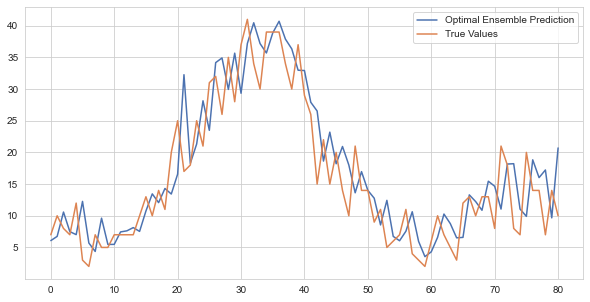

In [136]:
plt.figure(figsize=(10, 5))
plt.plot(optimal_ensemble_prediction, label='Optimal Ensemble Prediction')
plt.plot(np.linspace(0,80,81), y_val, label='True Values')
plt.legend()
plt.show()

In [137]:
mse = mean_squared_error(y_val, optimal_ensemble_prediction)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 29.41582281984351


## Test Set

In [138]:
test = create_lagged_vars(test, columns, lags)
test = create_interaction_vars(test, ['station_max_temp_c', 'station_min_temp_c', 'station_avg_temp_c',
                                       'station_diur_temp_rng_c']
                                , ['reanalysis_precip_amt_kg_per_m2', 'station_precip_mm'])
test['seasonal_feature'] = test['weekofyear'].apply(map_week_to_seasonal)

/var/folders/pj/9y_1xfsd6hgdycw5q9sfcq5w0000gn/T/ipykernel_43117/2525416368.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column}_lag{lag}'] = df[column].shift(lag)


In [139]:
X_test = test.drop('total_cases', axis=1)[selected_features]
y_test = test['total_cases']

In [140]:
train = sj.iloc[:train_size + val_size]

In [141]:
train = create_lagged_vars(train, columns, lags)
train = create_interaction_vars(train, ['station_max_temp_c', 'station_min_temp_c', 'station_avg_temp_c',
                                       'station_diur_temp_rng_c']
                                , ['reanalysis_precip_amt_kg_per_m2', 'station_precip_mm'])
train['seasonal_feature'] = train['weekofyear'].apply(map_week_to_seasonal)

/var/folders/pj/9y_1xfsd6hgdycw5q9sfcq5w0000gn/T/ipykernel_43117/2525416368.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column}_lag{lag}'] = df[column].shift(lag)


In [142]:
X_train = train.drop('total_cases', axis=1)[selected_features]
y_train = train['total_cases']

In [143]:
models = [
    RandomForestRegressor(),
    MLPRegressor(),
    KernelRidge(),
    GradientBoostingRegressor(),
    TPOTRegressor(generations=5, population_size=50, verbosity=2)
]

for model in models:
    model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -199.98937199943515

Generation 2 - Current best internal CV score: -199.98937199943515

Generation 3 - Current best internal CV score: -199.98937199943515

Generation 4 - Current best internal CV score: -199.98937199943515

Generation 5 - Current best internal CV score: -199.98937199943515

Best pipeline: RidgeCV(SelectPercentile(input_matrix, percentile=6))


In [145]:
predictions = np.column_stack([
    model.predict(X_test) for model in models
])

In [146]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=len(models))
    sigma = pm.HalfNormal('sigma', sigma=10)

    mu = alpha + tt.dot(predictions, beta)
    observed = pm.Normal('observed', mu=mu, sigma=sigma, observed=y_test)
    
    trace = pm.sample(2000, tune=1000)

alpha_post = np.mean(trace['alpha'])
beta_post = np.mean(trace['beta'], axis=0)

final_prediction = alpha_post + np.dot(predictions, beta_post)
ci_lower, ci_upper = np.percentile(final_prediction, [2.5, 97.5])

/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 51 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.


In [147]:
alpha_samples = trace['alpha']
beta_samples = trace['beta']

In [148]:
ensemble_predictions_samples = np.array([
    alpha_sample + np.dot(predictions, beta_sample)
    for alpha_sample, beta_sample in zip(alpha_samples, beta_samples)
])

ci_lower, ci_upper = np.percentile(ensemble_predictions_samples, [2.5, 97.5], axis=0)

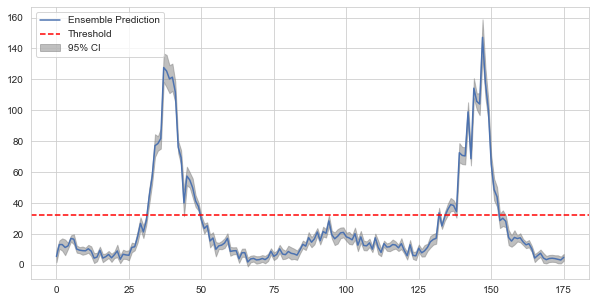

In [149]:
plt.figure(figsize=(10, 5))
plt.plot(final_prediction, label='Ensemble Prediction')
plt.fill_between(np.arange(len(final_prediction)), ci_lower, ci_upper, color='gray', alpha=0.5, label='95% CI')
plt.axhline(y=32, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.show()

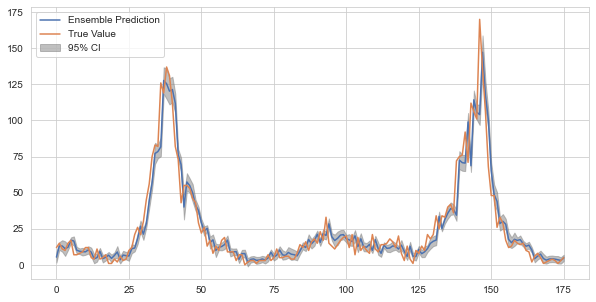

In [155]:
plt.figure(figsize=(10, 5))
plt.plot(final_prediction, label='Ensemble Prediction')
plt.fill_between(np.arange(len(final_prediction)), ci_lower, ci_upper, color='gray', alpha=0.5, label='95% CI')

plt.plot(np.linspace(0,175,176),y_test, label='True Value')

plt.legend()
plt.savefig("results.png",dpi=500)

plt.show()

In [154]:
mse = mean_squared_error(y_test, final_prediction)
print(f'Mean Squared Error: {mse}')
mae = mean_absolute_error(y_test, final_prediction)
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 113.49808635991006
Mean Absolute Error: 6.3895704422461925


In [156]:
y_test.index = np.linspace(0,175,176)

In [157]:
c_u = pd.DataFrame(ci_upper, columns = ['ci_upper'])
warnings = y_test[c_u['ci_upper'] >= 32]

In [158]:
c1 = pd.DataFrame(y_test[y_test >= 32].index)
c2 = pd.DataFrame(warnings.index)

In [159]:
cc = pd.merge(c1,c2,how = 'inner')

In [160]:
new_precise = warnings[warnings>=32].shape[0]/warnings.shape[0]
new_recall = cc.shape[0]/c1.shape[0]

In [161]:
new_precise,new_recall

(0.8780487804878049, 0.9)